In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import azureml
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
from azureml.core.run import Run 
import sys
import os

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path
import glob2 as glob
import random
import pickle
import cv2

# Display F. Chollet example
from IPython.display import Image, display
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from skimage.transform import rescale, resize, downscale_local_mean

from cgmml.common.evaluation.eval_utilities import download_model

REPO_DIR = Path(os.getcwd()).parents[2].absolute()

In [3]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


### Connect to azureml workspace

In [4]:
workspace = Workspace.from_config()
workspace

Workspace.create(name='cgm-ml-prod-ci-azml', subscription_id='9b5bbfae-d5d1-4aae-a2ca-75159c0c887d', resource_group='cgm-ml-prod-ci-rg')

### Specify experiment and run_id to download model

In [5]:
experiment_name = "q3-depthmap-plaincnn-height-95k"
run_id = "q3-depthmap-plaincnn-height-95k_1629821224_3ce63344"  # Run 2
input_location = 'outputs/best_model.ckpt'
name = 'best_model.ckpt'
output_location = (REPO_DIR / 'data' / experiment_name)

In [6]:
download_model(workspace=workspace, 
              experiment_name=experiment_name,
              run_id=run_id,
              input_location=input_location,
              output_location=output_location)

2021-09-22 10:31:26,114 - INFO - Successfully downloaded model - /Users/jasmin/CGM_local/cgm-ml/cgmml/common/evaluation/eval_utilities.py: line 414


In [7]:
print(output_location)

/Users/jasmin/CGM_local/cgm-ml/data/q3-depthmap-plaincnn-height-95k


In [8]:
model_file_path = (output_location / 'outputs' / 'best_model.ckpt')
print(model_file_path)

/Users/jasmin/CGM_local/cgm-ml/data/q3-depthmap-plaincnn-height-95k/outputs/best_model.ckpt


In [9]:
model = tf.keras.models.load_model(model_file_path, compile=False)

2021-09-22 10:31:43.976005: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 10:31:43.984733: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Compile the model.
model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 180, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 90, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 90, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 90, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 45, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 45, 128)       7

### Download dataset and find some examples

In [ ]:
# ALREADY DOWNLOADED
#dataset = Dataset.get_by_name(workspace, name='anon-depthmap-mini')
#dataset.download(target_path='./dataset', overwrite=False)

In [141]:
! ls ./dataset/scans/1585013033-l9ucees2h5

100 101 102


In [142]:
scan_paths = ["./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_000.p", 
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_014.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_000.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_006.p"]

In [143]:
#REMOVE THIS - this is bad!
image_target_height = 240
image_target_width = 180
targets_indices = [0]

def tf_load_pickle(path, max_value):
    def py_load_pickle(path, max_value):
        depthmap, targets = pickle.load(open(path.numpy(), "rb"))
        depthmap = preprocess_depthmap(depthmap)
        depthmap = depthmap / max_value
        depthmap = tf.image.resize(depthmap, (image_target_height, image_target_width))
        targets = preprocess_targets(targets, targets_indices)
        return depthmap, targets

    depthmap, targets = tf.py_function(py_load_pickle, [path, max_value], [tf.float32, tf.float32])
    depthmap.set_shape((image_target_height, image_target_width, 1))
    targets.set_shape((len(targets_indices,)))
    return depthmap, targets

def preprocess_depthmap(depthmap): # idk if i need this
    # TODO here be more code.
    return depthmap.astype("float32")

def preprocess_targets(targets, targets_indices):
    if targets_indices is not None:
        targets = targets[targets_indices]
    return targets.astype("float32")

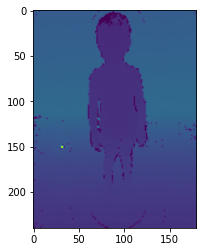

In [144]:
normalization_value = 7.5

depthmap0, target0 = tf_load_pickle(scan_paths[0], normalization_value)
plt.imshow(depthmap0)
plt.show()

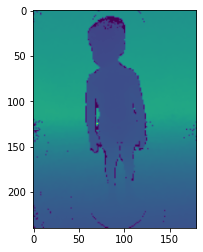

In [145]:
depthmap1, target1 = tf_load_pickle(scan_paths[1], normalization_value)
plt.imshow(depthmap1)
plt.show()

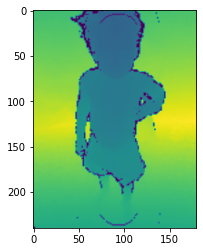

In [146]:
depthmap2, target2 = tf_load_pickle(scan_paths[2], normalization_value)
plt.imshow(depthmap2)
plt.show()

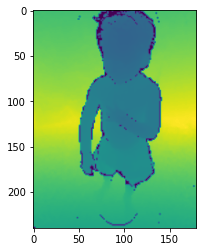

In [147]:
depthmap3, target3 = tf_load_pickle(scan_paths[3], normalization_value)
plt.imshow(depthmap3)
plt.show()

### The gradcam algorithm

In [148]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print("pred_index = ", pred_index)
            print("preds[0] = ", preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


### Prepare depthmap

In [149]:
print(type(depthmap0))
print(depthmap0.shape)

depthmap_np0 = np.array(depthmap0)
print(type(depthmap_np0))
print(depthmap_np0.shape)

depthmap_array0 = depthmap_np0.reshape(1, 240, 180, 1)
print(type(depthmap_array0))
print(depthmap_array0.shape)

save_as_filename0 = "grad_cam_result_cgm_depthmap0.jpg"

<class 'tensorflow.python.framework.ops.EagerTensor'>
(240, 180, 1)
<class 'numpy.ndarray'>
(240, 180, 1)
<class 'numpy.ndarray'>
(1, 240, 180, 1)


In [150]:
print(type(depthmap1))
print(depthmap1.shape)

depthmap_np1 = np.array(depthmap1)
print(type(depthmap_np1))
print(depthmap_np1.shape)

depthmap_array1 = depthmap_np1.reshape(1, 240, 180, 1)
print(type(depthmap_array1))
print(depthmap_array1.shape)

save_as_filename1 = "grad_cam_result_cgm_depthmap1.jpg"

<class 'tensorflow.python.framework.ops.EagerTensor'>
(240, 180, 1)
<class 'numpy.ndarray'>
(240, 180, 1)
<class 'numpy.ndarray'>
(1, 240, 180, 1)


In [151]:
print(type(depthmap2))
print(depthmap2.shape)

depthmap_np2 = np.array(depthmap2)
print(type(depthmap_np2))
print(depthmap_np2.shape)

depthmap_array2 = depthmap_np2.reshape(1, 240, 180, 1)
print(type(depthmap_array2))
print(depthmap_array2.shape)

save_as_filename2 = "grad_cam_result_cgm_depthmap2.jpg"

<class 'tensorflow.python.framework.ops.EagerTensor'>
(240, 180, 1)
<class 'numpy.ndarray'>
(240, 180, 1)
<class 'numpy.ndarray'>
(1, 240, 180, 1)


In [152]:
print(type(depthmap3))
print(depthmap3.shape)

depthmap_np3 = np.array(depthmap3)
print(type(depthmap_np3))
print(depthmap_np3.shape)

depthmap_array3 = depthmap_np3.reshape(1, 240, 180, 1)
print(type(depthmap_array3))
print(depthmap_array3.shape)

save_as_filename3 = "grad_cam_result_cgm_depthmap3.jpg"

<class 'tensorflow.python.framework.ops.EagerTensor'>
(240, 180, 1)
<class 'numpy.ndarray'>
(240, 180, 1)
<class 'numpy.ndarray'>
(1, 240, 180, 1)


### Create heatmap

pred_index =  tf.Tensor(0, shape=(), dtype=int64)
preds[0] =  tf.Tensor([90.183136], shape=(1,), dtype=float32)
pred_index =  tf.Tensor(0, shape=(), dtype=int64)
preds[0] =  tf.Tensor([90.77061], shape=(1,), dtype=float32)
pred_index =  tf.Tensor(0, shape=(), dtype=int64)
preds[0] =  tf.Tensor([86.009056], shape=(1,), dtype=float32)
pred_index =  tf.Tensor(0, shape=(), dtype=int64)
preds[0] =  tf.Tensor([83.31084], shape=(1,), dtype=float32)


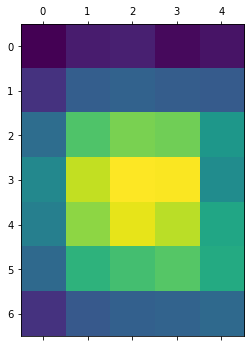

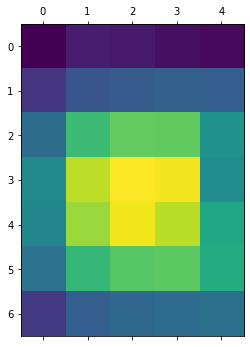

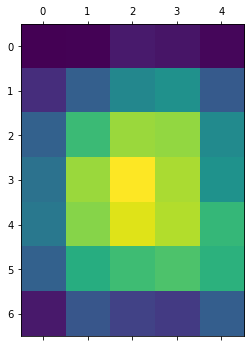

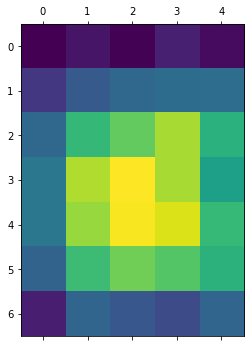

In [153]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap0 = make_gradcam_heatmap(depthmap_array0, model, 'conv2d_11')
heatmap1 = make_gradcam_heatmap(depthmap_array1, model, 'conv2d_11')
heatmap2 = make_gradcam_heatmap(depthmap_array2, model, 'conv2d_11')
heatmap3 = make_gradcam_heatmap(depthmap_array3, model, 'conv2d_11')

# Display heatmap
plt.matshow(heatmap0)
plt.matshow(heatmap1)
plt.matshow(heatmap2)
plt.matshow(heatmap3)
plt.show()

In [179]:
def save_and_display_gradcam(dmap_array, heatmap, cam_path, alpha=0.4):
    
    #dmap_array = dmap.depthmap_arr.reshape(1, 240, 180, 1)
    print(dmap_array.shape)
    print("dmap_array.shape[0]", dmap_array.shape[0])
    print("dmap_array.shape[1]", dmap_array.shape[1])
    print("dmap_array.shape[2]", dmap_array.shape[2])
    print("dmap_array.shape[3]", dmap_array.shape[3])
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    print("jet_heatmap.shape", jet_heatmap.size)
    
    jet_heatmap = jet_heatmap.resize((dmap_array.shape[2], dmap_array.shape[1]))
    
    print("jet_heatmap.shape", jet_heatmap.size)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    ## TODO - fix dimensions!! how do i do this later with batches - for now: strip first batch dim
    dmap_array = dmap_array[0, :, :, :]
    print(dmap_array.shape)
    superimposed_img = jet_heatmap * alpha + dmap_array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    print("superimposed_img.shape ", superimposed_img.size)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    
    plt.imshow(dmap_array)
    plt.show()

(1, 240, 180, 1)
4
dmap_array.shape[0] 1
dmap_array.shape[1] 240
dmap_array.shape[2] 180
dmap_array.shape[3] 1
jet_heatmap.shape (5, 7)
jet_heatmap.shape (180, 240)
(240, 180, 1)
superimposed_img.shape  (180, 240)


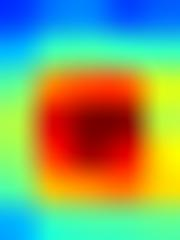

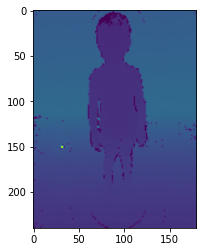

In [178]:
save_and_display_gradcam(depthmap_array0, heatmap0, save_as_filename0)

(1, 240, 180, 1)
dmap_array.shape[0] 1
dmap_array.shape[1] 240
dmap_array.shape[2] 180
dmap_array.shape[3] 1
jet_heatmap.shape (5, 7)
jet_heatmap.shape (180, 240)
(240, 180, 1)
superimposed_img.shape  (180, 240)


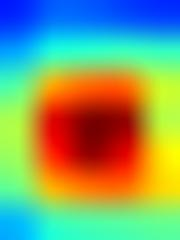

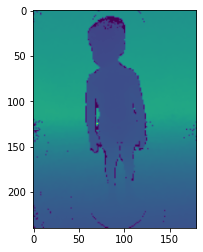

In [180]:
save_and_display_gradcam(depthmap_array1, heatmap1, save_as_filename1)

(1, 240, 180, 1)
dmap_array.shape[0] 1
dmap_array.shape[1] 240
dmap_array.shape[2] 180
dmap_array.shape[3] 1
jet_heatmap.shape (5, 7)
jet_heatmap.shape (180, 240)
(240, 180, 1)
superimposed_img.shape  (180, 240)


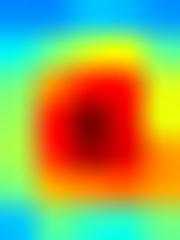

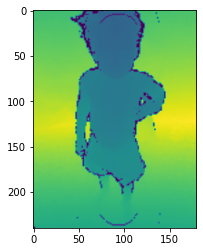

In [181]:
save_and_display_gradcam(depthmap_array2, heatmap2, save_as_filename2)

(1, 240, 180, 1)
dmap_array.shape[0] 1
dmap_array.shape[1] 240
dmap_array.shape[2] 180
dmap_array.shape[3] 1
jet_heatmap.shape (5, 7)
jet_heatmap.shape (180, 240)
(240, 180, 1)
superimposed_img.shape  (180, 240)


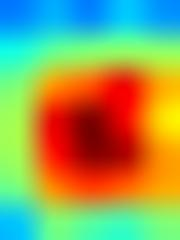

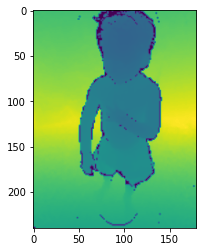

In [182]:
save_and_display_gradcam(depthmap_array3, heatmap3, save_as_filename3)